# I wanted to compare the HSP planner with a SAT-based approach. But, turning the planning problem into a SAT problem was tougher than I thought, and I need more time to figure out the library. So, I used the FF planner for now, as it's well-known and works well, to compare with the HSP planner.After running some benchmarks, I've drawn conclusions based on the results of comparing the HSP and FF planners.

## I spent few days encode the planning problem into SAT problem, I am still checking out the pddl4j class and functions, to see what can I after parsing the problem in pddl4j and instantiate that problem.

## I still did not manage to encode it into DIMACS to be able to run in SAT solver. I am stuck on the calling the preconditions, effects (both positive and negative). though, I am still exploring the pddl4j library.

## I also found Hubert's sat_planner, https://github.com/fiorinoh/satplanner/blob/main/src/fr/uga/pddl4j/tutorial/satplanner/SATEncoding.java
## However, the code based on pdd4j 3.8.3. with version 4.0.0 few classes have been changed such as CodedProblem , BitState, BitOp to Problem, State, BitSet. 

In [ ]:
import subprocess
import matplotlib.pyplot as plt
import csv
import re

In [2]:
# Define benchmarks and planners
benchmarks = ['blocks', 'depot', 'gripper', 'logistic']
planners = ['hsp', 'ff']

In [8]:
def extract_runtime_and_makespan(output):
    # Extract total runtime
    match = re.search(r'(\d+\.\d+)\s*seconds total time', output)
    if match:
        runtime_match = float(match.group(1))
#         print("Recognized runtime:", runtime_match)
    else:
        print("Runtime not found in the output.")

    # Extract makespan by counting the highest action number
    action_matches = re.findall(r'(\d+):', output)
    if action_matches:
        # Convert all matches to integers and get the highest value
        makespan = max(map(int, action_matches)) + 1
    else:
        raise ValueError("Unable to extract makespan from the output.")
    return runtime_match, makespan

In [9]:
def execute_planner(planner, benchmark):
    if planner == 'hsp':
        cmd = f"java -cp classes:lib/pddl4j-4.0.0.jar fr.uga.pddl4j.planners.statespace.HSP pddl/domain_{benchmark}.pddl pddl/p001_{benchmark}.pddl"
    else: # assuming FF planner
        cmd = f"java -cp classes:lib/pddl4j-4.0.0.jar fr.uga.pddl4j.planners.statespace.FF pddl/domain_{benchmark}.pddl pddl/p001_{benchmark}.pddl"
    
    output = subprocess.check_output(cmd, shell=True).decode('utf-8')
    # Parse the output to get runtime and makespan
#     print(output)
    try:
        runtime, makespan = extract_runtime_and_makespan(output)
    except ValueError as e:
        print("Error:", e)
        print("Planner Output:\n", output)
        raise
    
    return runtime, makespan

In [10]:
# Example usage:
# benchmark = "blocks"  # Just an example, replace with the actual benchmark you're using
# planner = "hsp"  # or "ff"
# runtime, makespan = execute_planner(planner, benchmark)
# print(f"Runtime for {benchmark} using {planner}: {runtime} seconds")
# print(f"Makespan for {benchmark} using {planner}: {makespan} actions")

In [11]:
# runtime,makespan = execute_planner(,)
# print(f"Runtime for {benchmark} using {planner}: {runtime} seconds")
# print(f"Makespan for {benchmark} using {planner}: {makespan} actions")

In [12]:
# Data collection
results = {}
for benchmark in benchmarks:
    for planner in planners:
        runtime, makespan = execute_planner(planner, benchmark)
        if benchmark not in results:
            results[benchmark] = {}
        results[benchmark][planner] = {'runtime': runtime, 'makespan': makespan}


In [15]:
results

{'blocks': {'hsp': {'runtime': 0.07, 'makespan': 6},
  'ff': {'runtime': 0.07, 'makespan': 10}},
 'depot': {'hsp': {'runtime': 0.1, 'makespan': 10},
  'ff': {'runtime': 0.1, 'makespan': 12}},
 'gripper': {'hsp': {'runtime': 0.15, 'makespan': 9},
  'ff': {'runtime': 0.09, 'makespan': 9}},
 'logistic': {'hsp': {'runtime': 0.15, 'makespan': 20},
  'ff': {'runtime': 0.1, 'makespan': 20}}}

In [13]:
# Save to CSV
with open('results.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['Benchmark', 'Planner', 'Runtime', 'Makespan'])
    for benchmark, data in results.items():
        for planner, metrics in data.items():
            writer.writerow([benchmark, planner, metrics['runtime'], metrics['makespan']])


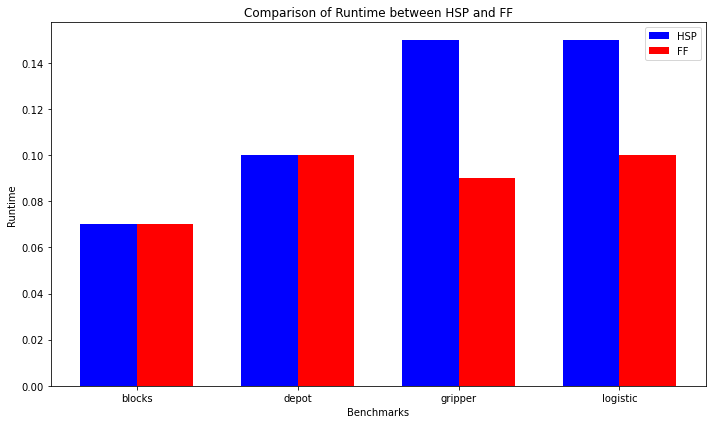

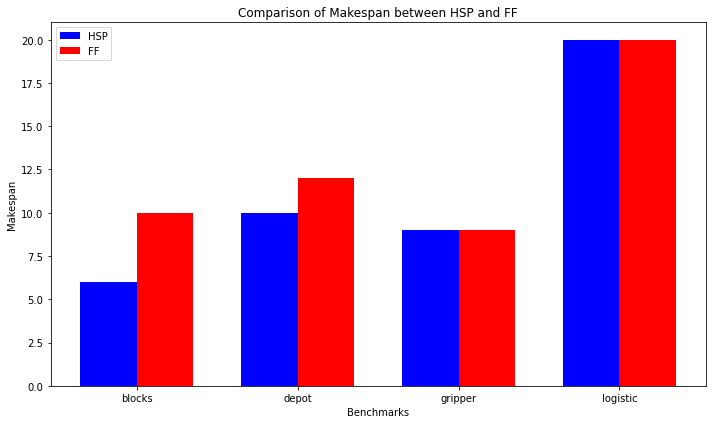

In [17]:
# Order benchmarks by HSP runtime for visualization
ordered_benchmarks = sorted(benchmarks, key=lambda x: results[x]['hsp']['runtime'])

# Visualization
for metric in ['runtime', 'makespan']:
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(ordered_benchmarks))
    
    hsp_values = [results[domain]['hsp'][metric] for domain in ordered_benchmarks]
    ff_values = [results[domain]['ff'][metric] for domain in ordered_benchmarks]
    
    # Create bar charts
    plt.bar(index, hsp_values, bar_width, color='blue', label='HSP')
    plt.bar([i+bar_width for i in index], ff_values, bar_width, color='red', label='FF')
    
    plt.xlabel('Benchmarks')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} between HSP and FF')
    plt.xticks([i+bar_width/2 for i in index], ordered_benchmarks)
    plt.legend()
    plt.tight_layout()
    plt.show()

My conclusion :
- In terms of runtime, FF is faster in 2 out of the 4 domains (Gripper and Logistic), while in the other two domains (Blocks and Depot), both planners perform equally.
- In terms of makespan, HSP produces shorter plans in 2 out of the 4 domains (Blocks and Depot), and in the other two domains (Gripper and Logistic), both planners produce plans of the same length.
+ Overall, FF tends to be faster in terms of runtime, HSP tends to produce shorter plans (lower makespan) in certain domains. The "best" planner would depend on the specific requirements: if speed of finding a plan is more critical, FF seems better; if the quality (length) of the plan is more important, HSP might be preferred.